<a href="https://colab.research.google.com/github/DommiiUdomp/Dommii/blob/main/eusat_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Download Dataset**

In [21]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

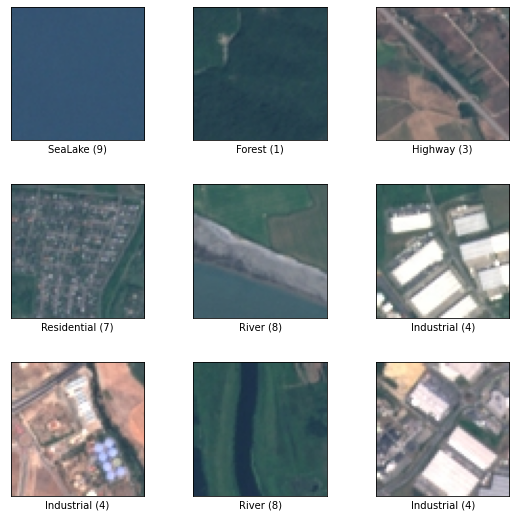

In [22]:
ds, info = tfds.load('eurosat', split='train', with_info=True)
fig = tfds.show_examples(ds, info)

In [23]:
print(info.features["label"].num_classes)
print(info.features["label"].names)
print(info.features["label"].int2str(7)) 

10
['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Residential


In [24]:
print(info.features.shape)
print(info.features.dtype)
print(info.features['image'].shape)
print(info.features['image'].dtype)

{'image': (64, 64, 3), 'label': (), 'filename': ()}
{'image': tf.uint8, 'label': tf.int64, 'filename': tf.string}
(64, 64, 3)
<dtype: 'uint8'>


In [25]:
print(list(info.splits.keys()))

['train']


In [26]:
print(info.splits['train'].num_examples)
print(info.splits['train'].filenames)
print(info.splits['train'].num_shards)

27000
['eurosat-train.tfrecord-00000-of-00001']
1


In [27]:
image, label = tfds.as_numpy(tfds.load('eurosat',
                                       split='train',
                                       batch_size=-1,
                                       as_supervised=True))

print(type(image), image.shape)

<class 'numpy.ndarray'> (27000, 64, 64, 3)


In [28]:
image.shape

(27000, 64, 64, 3)

In [29]:
label.shape

(27000,)

In [30]:
# change them to integers in alphabetical order
label_names, label_y = np.unique(label, return_inverse=True)
np.array(np.unique(label_y, return_counts=True)).T

array([[   0, 3000],
       [   1, 3000],
       [   2, 3000],
       [   3, 2500],
       [   4, 2500],
       [   5, 2000],
       [   6, 2500],
       [   7, 3000],
       [   8, 2500],
       [   9, 3000]])

In [31]:
label_Dict = dict(zip(np.unique(label), info.features["label"].names))
print(label_Dict)

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


In [101]:
aa = np.array(np.unique(label_y, return_counts=True)).T
bb = np.array(info.features["label"].names)

In [130]:
for i in range(len(bb)):
  print(aa[i].astype(int), bb[i])

[   0 3000] AnnualCrop
[   1 3000] Forest
[   2 3000] HerbaceousVegetation
[   3 2500] Highway
[   4 2500] Industrial
[   5 2000] Pasture
[   6 2500] PermanentCrop
[   7 3000] Residential
[   8 2500] River
[   9 3000] SeaLake


# **Data Preprocessing**

In [32]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread, imshow, subplots, show

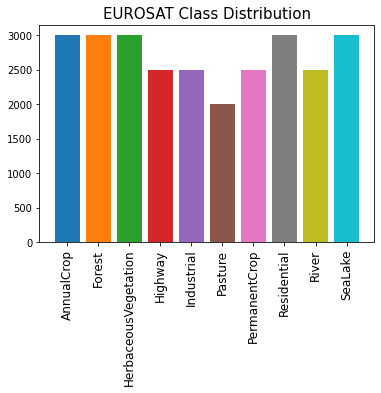

In [133]:
fig = plt.plot(figsize = (10,5))
for i in range(len(bb)) :
  xx, hh = aa[i]
  plt.bar(bb[i], hh, align='center')
  plt.xticks(fontsize=12, rotation=90)
  plt.title('EUROSAT Class Distribution', fontsize=15);

plt.show()

8
River


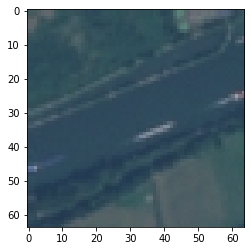

In [136]:
# test the labels and images 
tmp = 3333
img = image[tmp]

print(label[tmp])
print(label_Dict[label[tmp]])
plt.imshow(img)

In [167]:
#Plot prepared Data
def random_plot(X,y):
  num_test_images = X.shape[0]
  random_inx = np.random.choice(num_test_images, 32)
  random_test_images = X[random_inx, ...]
  random_test_labels = y[random_inx, ...]
  
  plt.figure(figsize=(20, 8))
  for i in range(32):
    plt.subplot(4, 8, i+1, xticks=[], yticks=[])
    plt.imshow(random_test_images[i])
    plt.title(label_Dict[random_test_labels[i]])

  plt.show()

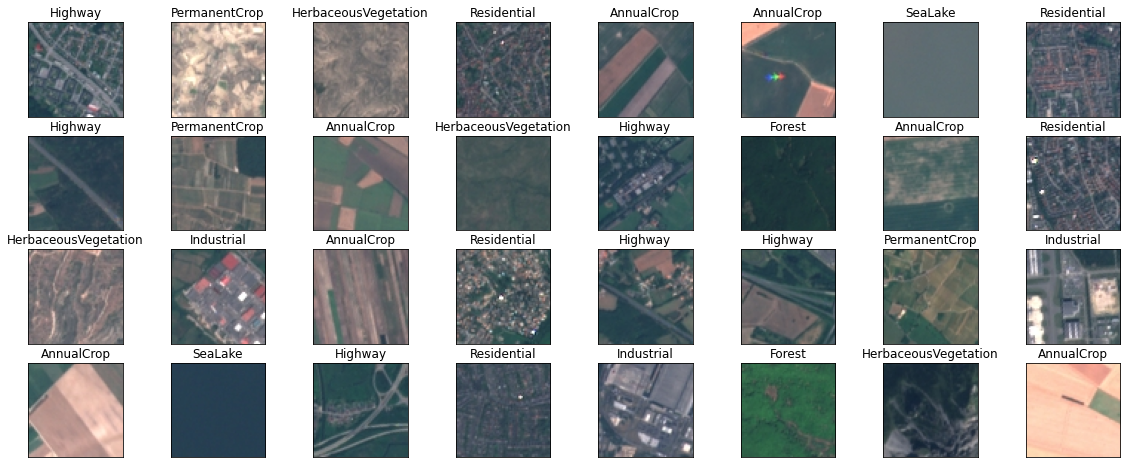

In [168]:
random_plot(image,label)

In [142]:
from sklearn.utils import shuffle

smallest_class = np.argmin(np.bincount(label)) # find the smallest class
print(f' the smallest class: {smallest_class}')

num_classes = len(np.array(np.unique(label))) # number of classes
print(f' the number of classes: {num_classes}')

smallest_class_obs = np.where(label == smallest_class)[0] # observations in smallest class
print(f' observations in smallest class:{smallest_class_obs.shape}')

# Get 2000 observations from each class
indBal = np.empty(0, dtype=int)
for i in range(num_classes):
  indTemp = shuffle(np.where(label == i)[0], random_state=42)[0:smallest_class_obs.shape[0]]
  indBal = np.concatenate([indBal, indTemp])

# shuffle the balanced index
indBal = shuffle(indBal, random_state = 101)

 the smallest class: 5
 the number of classes: 10
 observations in smallest class:(2000,)


In [143]:
label_bal = label[indBal]
image_bal = image[indBal]

print(label_bal.shape)
print(image_bal.shape)

(20000,)
(20000, 64, 64, 3)


# **Visualize cross-validation indices** 

In [151]:
from sklearn.model_selection import TimeSeriesSplit, KFold, ShuffleSplit, StratifiedKFold, GroupShuffleSplit, GroupKFold
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedGroupKFold

from matplotlib.patches import Patch

In [146]:
from sklearn.model_selection import StratifiedShuffleSplit

splite = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=101)
print(splite.get_n_splits(image_bal, label_bal))

for train_index, test_index in splite.split(image_bal, label_bal):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = image_bal[train_index], image_bal[test_index]
  y_train, y_test = label_bal[train_index], label_bal[test_index]

1
TRAIN: [13766  8905  5176 ... 12158  1555 10242] TEST: [16086  3312 14479 ... 14168  9997 14857]


In [157]:
np.array(np.unique(y_train, return_counts=True)).T

array([[   0, 1400],
       [   1, 1400],
       [   2, 1400],
       [   3, 1400],
       [   4, 1400],
       [   5, 1400],
       [   6, 1400],
       [   7, 1400],
       [   8, 1400],
       [   9, 1400]])

In [175]:
from tensorflow.keras.utils import to_categorical

X_train = X_train.astype('float64') # Convert train and test images into 'float64' type
X_test = X_test.astype('float64')
#Normalize the images data #minimum and maximum values equal to 0 and 1 respectively.
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

y_train = y_train.astype('int64') # Convert train and test labels into 'int64' type
y_test = y_test.astype('int64')
# convert class vectors to binary class matrices
y_train_class = to_categorical(y_train, num_classes)
y_test_class = to_categorical(y_test, num_classes)

print(f'Min: {X_train.min()}, Max: {X_train.max()}')
print(f'New_Min: {X_train_scaled.min()}, New_Max: {X_train_scaled.max()}')

Min: 0.0, Max: 255.0
New_Min: 0.0, New_Max: 1.0


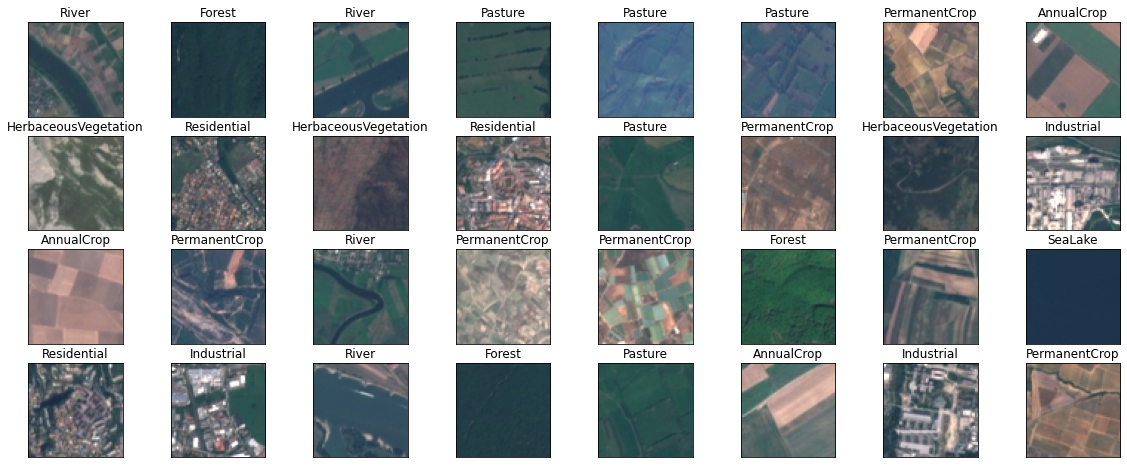

In [178]:
random_plot(X_train_scaled,y_train)

# **Gray Image**

In [202]:
from skimage.color import rgb2gray

In [180]:
#Create an RGB representation of a gray-level image.
#Manual
X_train_BW = np.zeros([X_train_scaled.shape[0], X_train_scaled.shape[1], X_train_scaled.shape[2]])
X_test_BW = np.zeros([X_test_scaled.shape[0], X_test_scaled.shape[1],X_test_scaled.shape[2]])
#or
X_train_BW = np.average(X_train_scaled, axis=-1)
X_test_BW = np.average(X_test_scaled, axis=-1)

In [182]:
X_train_g = rgb2gray(X_train_scaled)
X_test_g = rgb2gray(X_test_scaled)

In [200]:
np.random.choice(X_train_scaled.shape[0])

7561

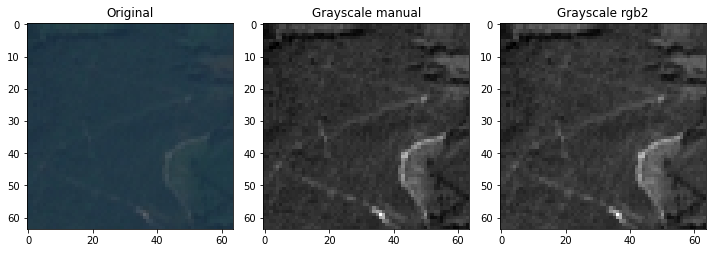

In [201]:
from scipy.sparse.construct import random
#Plot compare
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
ax = axes.ravel()

a = np.random.choice(X_train_scaled.shape[0])
ax[0].imshow(X_train_scaled[a])
ax[0].set_title("Original")
ax[1].imshow(X_train_BW[a], cmap=plt.cm.gray)
ax[1].set_title("Grayscale manual")
ax[2].imshow(X_train_g[a], cmap=plt.cm.gray)
ax[2].set_title("Grayscale rgb2")

fig.tight_layout()
plt.show()

In [203]:
print(X_train_scaled.shape)
print(X_train_BW.shape)
print(X_train_g.shape)

(14000, 64, 64, 3)
(14000, 64, 64)
(14000, 64, 64)


# **Build the model**

In [ ]:
#continue.....

In [204]:
from time import time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.utils.fixes import loguniform

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, cross_val_score, cross_validate, cross_val_predict